# ME144 Final Project
Eric Kuhn, Machlan Pettersen, Luke Marcoon

## Objective

Develop a forecast model to determine the snow pile volume necessary to cool a building in a specific location from April 1 to October 1

## Assumptions

* The calculation of irradiation is not corrected for the variation of position of the sun relative to the specific location (Discuss)
* All heat transfer calculations are 1D. (Discuss)
* Conduction heat transfer is assumed to be quasi-steady (Discuss)
* For convection over a flat plate, the regime is determined by the Richardson number:
$$
Ri = \frac{Gr}{Re^2}
$$
    * If the wind speed is lower than $0.15 \mathrm{m}/\mathrm{s}$, forced convection is negligible
    * If $Ri < 0.1$, natural convection is negligible
    * If $0.1 \leq Ri\leq10$, the regime is mixed convection (the total convection coefficient is the sum of the forced and natural convection coefficients.
    * If $Ri > 10$, forced convection is negligible
* To simplify forced convection your building roof top should be cubic. (Discuss)
* To reduce computing time, multiply the heat rate on the roof by 4 (one less face to assume one is always in shaded)
* Assume that the snow pile top has negligible curvature (i.e. it is assumed to be flat).
* Assume saturated soil. If sandy, $k_{soil}=2\mathrm{W}/\mathrm{m.K}$, if peat $k_{soil}=0.5\mathrm{W}/\mathrm{m.K}$
* The sensible heat rate by rain is 
$$
q''_{rain}=\rho_wC_{p,w}p(T_{wb}-T_s)
$$
where $\rho_w=1000\mathrm{kg/m}^3$, $C_{p,w}=4.19\mathrm{kJ}/\mathrm{kg.K}$, $p$ is the precipitation rate ($\mathrm{m/s}$) and $T_{wb}$ is the wet bulb temperature given here https://journals.ametsoc.org/view/journals/apme/50/11/jamc-d-11-0143.1.xml

## Deliverables

* Discuss the validity of simplifying assumptions
* Sketch your problems, thermal circuits when appropriate, and write your equations.
* As much as possible, use individual functions for your calculations


In [1]:
import sys  
sys.path.insert(0, '../Libraries/') 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import schemdraw as schem
import schemdraw.elements as e

import math
import scipy.constants as sc
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import sympy as sym

import thermodynamics as thermo
import HT_external_convection as extconv
import HT_natural_convection as natconv
import HT_internal_convection as intconv
import HT_thermal_resistance as res

In [2]:
xl = pd.ExcelFile('Climate/April-October-2020.xlsx')

## Available locations

In [3]:
xl.sheet_names 

['Canmore, AB',
 'Craftsbury, VT',
 'Bend, OR',
 'Boston, MA',
 'Bozeman, MT',
 'Essex Junction, VT',
 'Lake Placid, NY',
 'Minneapolis, MN',
 'Nagano City, Japan',
 'Randolph, VT',
 'Soldier Hollow, UT',
 'Villard de Lans, France']

## Lake Placid, NY study

In [4]:
loc = 'Lake Placid, NY'
weather = pd.read_excel("Climate/April-October-2020.xlsx",
                        sheet_name=loc,header=0,
                        converters= {'Date time': pd.to_datetime},)
weather = weather.set_index('Date time')
weather['Name'].head(1)

Date time
2020-04-01    Lake Placid, NY, United States
Name: Name, dtype: object

### Clean possible NaNs

In [5]:
weather['Solar Radiation'] = weather['Solar Radiation'].fillna(0.0)
weather['Cloud Cover'] = weather['Cloud Cover'].fillna(0.0)
weather['Precipitation'] = weather['Precipitation'].fillna(0.0)
# weather['Name'].head(-2)

In [6]:
weather = weather.fillna(0.0)

### Visual data check

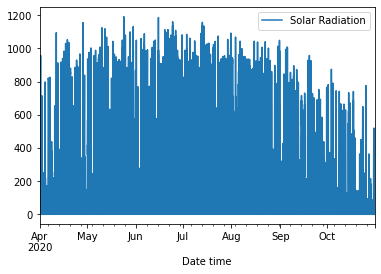

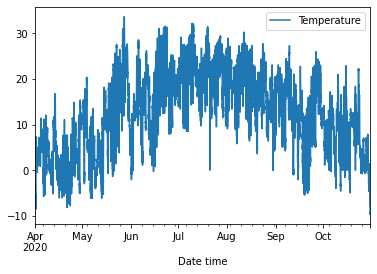

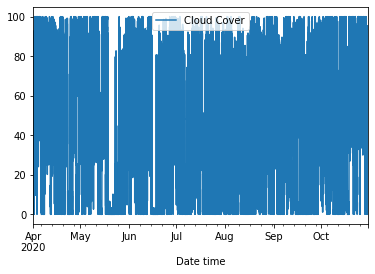

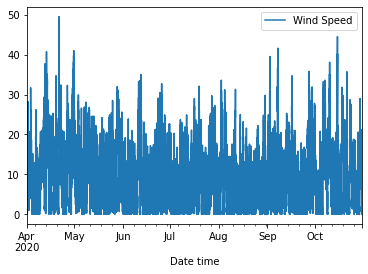

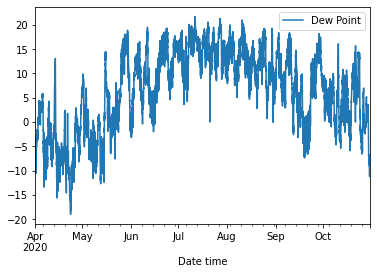

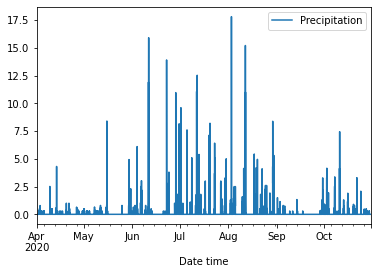

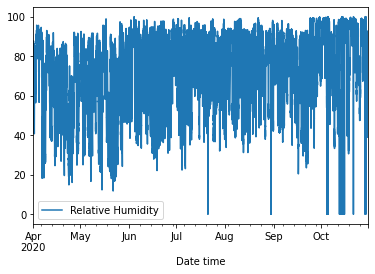

In [7]:
ax0 = weather.plot(y='Solar Radiation')
ax0 = weather.plot(y='Temperature')
ax0 = weather.plot(y='Cloud Cover')
ax0 = weather.plot(y='Wind Speed')
ax0 = weather.plot(y='Dew Point')
ax0 = weather.plot(y='Precipitation')
ax0 = weather.plot(y='Relative Humidity')

### Creation of the interpolation function

Note the definition of new functions. Use `U_atmospheric(t)`, `T_atmospheric(t)`, `sun_irradiation(t)`, `dew_point(t)`, `cloud_cover`, `relative_humidity` and `rain_rate`. These functions already include the appropriate clipping of unrealistic values

In [8]:
from scipy.interpolate import interp1d
interp_method = 'cubic'
t_data = np.arange(0,weather.shape[0]*15*60,15*60)
U_atm = np.abs(weather['Wind Speed'][:].to_numpy()/3.6) #converted from km/h to m/s
T_atm = weather['Temperature'][:].to_numpy()
q_sun = weather['Solar Radiation'][:].to_numpy()
# CC = weather['Cloud Cover'][:].to_numpy()
cc = weather['Cloud Cover'][:].to_numpy()/100. # converted from % to fraction
rh = weather['Relative Humidity'][:].to_numpy() # left as %
p_r = weather['Precipitation'][:].to_numpy()*1e-3/(15*60) #converted to mm to m/s 
T_dp = weather['Dew Point'][:].to_numpy()
f_U_atm = interp1d(t_data,U_atm,kind=interp_method)
def U_atmospheric(t):
    global f_U_atm
    return np.maximum(f_U_atm(t),0.)
f_T_atm = interp1d(t_data,T_atm,kind=interp_method)
def T_atmospheric(t):
    global f_T_atm
    return f_T_atm(t)
f_q_sun = interp1d(t_data,q_sun,kind=interp_method)
def sun_irradiation(t):
    global f_q_sun
    return np.maximum(f_q_sun(t),0.)
f_CC = interp1d(t_data,cc,kind=interp_method)
def cloud_cover(t):
    global f_CC
    return np.clip(f_CC(t),0.,1.)
f_T_dp = interp1d(t_data,T_dp,kind=interp_method)
def dew_point(t):
    global f_T_dp
    return f_T_dp(t)
f_RH = interp1d(t_data,rh,kind=interp_method)
def relative_humidity(t):
    global f_RH
    return np.clip(f_RH(t),0.,100.)
f_rain = interp1d(t_data,p_r,kind=interp_method)
def rain_rate(t):
    global f_rain
    return np.maximum(f_rain(t),0.)


### Importing libraries to solve heat transfer problem

In [9]:
import scipy.constants as csts
from scipy.integrate import solve_ivp
import thermodynamics as thermo
import HT_external_convection as extconv
import HT_natural_convection as natconv

### Convection heat transfer on upper surface

Where you write equations and text

In [10]:
def outsideconvection(Uinf, T_f,Tinf, air_f,Lplate, Ts):
    Re = np.abs(Uinf)*Lplate/air_f.nu
    Gr = natconv.Gr(beta=air_f.beta,DT=np.abs(Ts-Tinf),D=Lplate,nu=air_f.nu)
    Ra = natconv.Ra(beta=air_f.beta,DT=np.abs(Ts-Tinf),D=Lplate,nu=air_f.nu,alpha=air_f.alpha)
    if (Uinf < 0.15):
        ForcedConvection = False
        NaturalConvection = True
    else:
        Ri = Gr / Re**2
        if Ri < 0.1:
            ForcedConvection = True
            NaturalConvection = False
        elif Ri > 10:
            ForcedConvection = False
            NaturalConvection = True
        else:
            ForcedConvection = True
            NaturalConvection = True
    if ForcedConvection:
        if (Re <= 5e5):
            airflow = extconv.FlatPlate('laminar','isothermal',U_infty=Uinf,nu=air_f.nu,alpha=air_f.alpha, L=Lplate,xi=0,Re_xc= 5e5)
            airflow.average(Lplate)
            hconv_f = airflow.Nu_ave*air_f.k/Lplate
        elif Re > 5e5:
            airflow = extconv.FlatPlate('mixed','isothermal',U_infty=Uinf,nu=air_f.nu,alpha=air_f.alpha, L=Lplate,xi=0,Re_xc= 5e5)
            airflow.average(Lplate)
            hconv_f = airflow.Nu_ave*air_f.k/Lplate
    else:
        hconv_f = 0
    #Natural convection flux
    if NaturalConvection and Ra > 1e4:
        if Ts >= Tinf:
            airflow = natconv.FlatPlate(Ra,air_f.Pr,'upper','hot')
        else:
            airflow = natconv.FlatPlate(Ra,air_f.Pr,'upper','cold')
        hconv_n = airflow.Nu*air_f.k/Lplate
    else:
        hconv_n = 0
    #Total convection flux (here not a function of Ri)
    h = hconv_n + hconv_f
    qpp = h*(Tinf - Ts)
    
    return qpp

### Radiation between outer surface and sky

Correlation..


In [11]:
def skyradiation(Tdp,cc,Tinf,Ts):
    # Ts must be in Celsius
    eps_clear = 0.711 + 0.56*(Tdp/100.) + 0.73*(Tdp/100.)**2
    Ca = 1. + 0.02224*cc + 0.0035*cc**2 + 0.00028*cc**3
    Tsky = (Ca*eps_clear)**0.25*thermo.C2K(Tinf)
    qsky = eps_sky*csts.sigma*(Tsky**4 - thermo.C2K(Ts)**4)
    return qsky

### Heat transfer with rain

Equations


In [12]:
def T_wet_bulb(T,RH):
    return T * np.arctan(0.1515977*(RH + 8.313659)**0.5) + np.arctan(T + RH) \
            - np.arctan(RH - 1.676331) + 0.00391838*RH**1.5*np.arctan(0.023101*RH) \
            - 4.686035
def rain(pr,Tinf,RH,Ts):
    Twb = T_wet_bulb(Tinf,RH)
#     print("rain",pr,Twb,Tinf,RH,Ts)
    rho = 1000.
    Cp = 4.19e3
    return rho*Cp*pr*(Twb - Ts)
    

## Function to be solved

Conservation of energy equation

In [13]:
def f(t,T):
    global Lplate,k,H,eps,f_U_atm,f_T_atm,f_q_sun,rho,C_p,alpha_s,f_CC,f_T_dp
    # film temperature between ambient and upper surface
    Tinf = T_atmospheric(t)
    Uinf = U_atmospheric(t)
    
    T_f = (T[0]+Tinf)/2
    air_f = thermo.Fluid('air',T_f,"C")
    Tdp = dew_point(t)
    cc = cloud_cover(t)
    pr = rain_rate(t)
    rh = relative_humidity(t)
    
    
    qpp_sun = alpha_s*sun_irradiation(t)
    
    qpp_sky = skyradiation(Tdp,cc,Tinf,T[0])
    
    qpp_conv = outsideconvection(Uinf, T_f,Tinf, air_f,Lplate, T[0])
    
    qpp_rain = rain(pr,Tinf,rh,T[0])
    
    qpp_cond = k*(T[0] - T_s_lower)/H
    
    qpp_total = qpp_sun + qpp_sky + qpp_conv + qpp_rain - qpp_cond
    
    return qpp_total/(rho*C_p)
    

## Main code

### 1) Building Cooling Requirements 

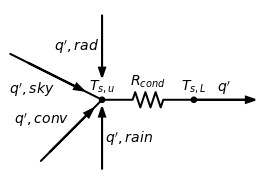

In [14]:
RB = []
RB.append(res.Resistance(name="$R_{conv}$", units="W/m"))
RB.append(res.Resistance(name="$R_{cond}$", units="W/m"))
RB.append(res.Resistance(name="$R_{conv,o}$", units="W/m"))
RB.append(res.Resistance(name="$R_{rad}$", units="W/m"))

d = schem.Drawing()

d.add(e.DOT, label = r"$T_{s,u}$")
d.add(e.RES, d = 'right', label = RB[1].name)
d.add(e.DOT, label = r"$T_{s,L}$")

L1 = d.add(e.LINE, toplabel = "$q',rad$", endpts = [[0, 2], [0, 1.5]])
d.labelI(L1, arrowofst = 0)
L1 = d.add(e.LINE, toplabel = "$q'$", endpts = [[3.5, 0], [4.5, 0]])
d.labelI(L1, arrowofst = 0)
L1 = d.add(e.LINE, botlabel = "$q',sky$", endpts = [[-3, 1.5], [0, 0]])
d.labelI(L1, arrowofst = 0)
L1 = d.add(e.LINE, toplabel = "$q',conv$", endpts = [[-2,-2], [0, 0]])

d.labelI(L1, arrowofst = 0)
L1 = d.add(e.LINE, botlabel = "$q',rain$", endpts = [[0, -2], [0, -0.5]])
d.labelI(L1, arrowofst = 0)
d.draw()

In [15]:
rho = 2000. #kg/m^3 concrete density
C_p = 880.  #J/kg*C concrete specific heat
R_wall = 7.27 #m^3K/W
H = 0.3048 #thickness of concrete warehouse walls: m
k = R_wall*H #thermal conductivity of the wall
alpha_s = 0.5
eps_sky = 1.
Lplate = 70.  #length of building
A = Lplate**2
T_s_lower = 20.

tmax = t_data[-1]
mask = np.where(t_data <= tmax)
sol = solve_ivp(f,[0,tmax],[-5],method='LSODA',t_eval=t_data[mask],max_step=10*60.)

### Output

Creation of two new columns, one for upper surface temperature, the other as the cooling energy needed to maintain target temperature on the lower surface.

In [16]:
weather['Tsu'] = sol.y[0]
weather['q_cool'] = np.maximum(k*(sol.y[0] - T_s_lower)/H*A,0.)

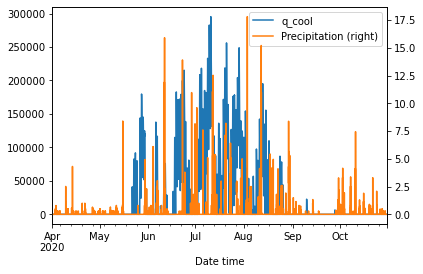

In [17]:
ax0 = weather.plot(y='q_cool')
weather.plot(y='Precipitation',ax=ax0, secondary_y=True)

In [18]:
weather['q_cool'].sum()*15*60/3600*1e-6
Q_cool_tot = (weather['q_cool'].sum()*15*60/3600*1e-6)*4 #Megawatts *4 for one side is always shaded
print(Q_cool_tot)

505.60174779503114


### 2) Snow-side Pipe Heat Extraction

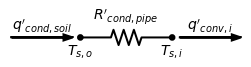

In [19]:
Rps = []
Rps.append(res.Resistance(name="$R'_{cond,pipe}$", units="W/m"))

d = schem.Drawing()
d.add(e.DOT, botlabel = r"$T_{s,o}$")
d.add(e.RES, d = 'right', label = Rps[0].name)
d.add(e.DOT, botlabel = r"$T_{s,i}$")
L1 = d.add(e.LINE, toplabel = "$q'_{cond,soil}$", endpts = [[-2.25, 0], [-0.25, 0]])
d.labelI(L1, arrowofst = 0)
L1 = d.add(e.LINE, toplabel = "$q'_{conv,i}$", endpts = [[3.25, 0], [5.25, 0]])
d.labelI(L1, arrowofst = 0)
d.draw()

In [20]:
Q = 0.045 #m^3/s
rho = 998 #kg/m^3
mdot = Q*rho
T_mi = 0. #C
T_mo = 2. #C
Cp = 4184. #J/kg*K

q_conv = mdot*Cp*(T_mo-T_mi)
print(q_conv)

375806.87999999995


### 3) Wood Chip Snow Pile Insulation

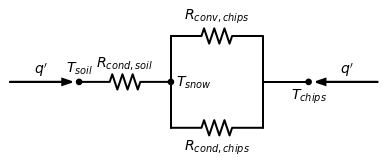

In [21]:
Rs = []
Rs.append(res.Resistance(name="$R_{cond,chips}$", units="W/m"))
Rs.append(res.Resistance(name="$R_{cond,soil}$", units="W/m"))
Rs.append(res.Resistance(name="$R_{conv,chips}$", units="W/m"))
Rs.append(res.Resistance(name="$R_{rad}$", units="W/m"))

d = schem.Drawing()
d.add(e.DOT, label = r"$T_soil$")
d.add(e.RES, d = 'right', label = Rs[0].name)
d.add(e.DOT, label = r"$T_{s,i}$")
R1 = d.add(e.RES, d = 'right', label = Rs[1].name)
d.add(e.DOT, label = r"$T_{s,o}$")
d.add(e.RES, d='right', label = Rs[2].name)
d.add(e.DOT, label="$T_\infty$")
L1 = d.add(e.LINE, toplabel = "$q'$", endpts = [[-2.25, 0], [-0.25, 0]])
d.labelI(L1, arrowofst = 0)
d.draw()

d = schem.Drawing()

d.add(e.DOT, label = r"$T_{soil}$")
R1 = d.add(e.RES, d = 'right', label = Rs[1].name)
d.add(e.DOT, rgtlabel = r"$T_{snow}$")
d.push()
d.add(e.LINE, d= 'up', l = 1.5)
d.add(e.RES, d='right', label = Rs[2].name)
d.add(e.LINE, d='down', l = 1.5)
d.pop()
d.add(e.LINE, d='down', l = 1.5)
d.add(e.RES, d='right', botlabel = Rs[0].name)
d.add(e.LINE, d= 'up', l = 1.5)
d.add(e.LINE,d='right',l=1.5)
d.add(e.DOT, botlabel="$T_{chips}$")

L1 = d.add(e.LINE, toplabel = "$q'$", endpts = [[-2.25, 0], [-0.25, 0]])
d.labelI(L1, arrowofst = 0)

L1 = d.add(e.LINE, toplabel = "$q'$", endpts = [[9, 0], [8.5, 0]])
d.labelI(L1, arrowofst = 0)
d.draw()

In [23]:
rho = 288.3 #density of moist woodchips/sawdust: kg/m^3
C_p = 185e5 #Heat capacity of moist woodchips/sawdust: J/kg*K
H = 0.3 #thickness of sawdust (from Sundsvall Hospital Paper): m
k = 0.35 #Thermal conductivity of moist sawdust (from Sundsvall Hospital Paper)
alpha_s = 0.5
eps_sky = 1.
Lplate = 70.  #length of building
A = Lplate**2
T_s_lower = 0.

tmax = t_data[-1]
mask = np.where(t_data <= tmax)
sol = solve_ivp(f,[0,tmax],[-5],method='LSODA',t_eval=t_data[mask],max_step=10*60.)

### 4) Building-side pipe